In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Rescaling, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input, RandomFlip, RandomRotation, RandomZoom,GlobalAveragePooling2D
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0,ResNet50,DenseNet121,InceptionV3,VGG16,VGG19
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
def create_dataset(directory, img_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    data = datagen.flow_from_directory(
        directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    return data

In [3]:
img_size = (224, 224)
batch_size = 32
train_dir = "train_limited"  
val_dir = "Val" 
test_dir = "Test"

In [4]:
dataset = create_dataset(train_dir, img_size, batch_size)
val_set = create_dataset(val_dir, img_size, batch_size)
test_set = create_dataset(test_dir, img_size, batch_size)

Found 17240 images belonging to 14 classes.
Found 3660 images belonging to 14 classes.
Found 3675 images belonging to 14 classes.


In [6]:
images, labels = next(dataset)
for i in range(9):  # take(1) gives just one batch
    print("Image shape:", images.shape)  # e.g., (32, 224, 224, 3)
    print("First image array:\n", images[i])  # Convert tensor to NumPy and print
    print("Corresponding label:", labels[i])

Image shape: (32, 224, 224, 3)
First image array:
 [[[0.2509804  0.14117648 0.227451  ]
  [0.2509804  0.14117648 0.227451  ]
  [0.2509804  0.14117648 0.227451  ]
  ...
  [0.16862746 0.09411766 0.10196079]
  [0.16862746 0.09411766 0.10196079]
  [0.16862746 0.09411766 0.10196079]]

 [[0.2509804  0.14117648 0.227451  ]
  [0.2509804  0.14117648 0.227451  ]
  [0.2509804  0.14117648 0.227451  ]
  ...
  [0.16862746 0.09411766 0.10196079]
  [0.16862746 0.09411766 0.10196079]
  [0.16862746 0.09411766 0.10196079]]

 [[0.2509804  0.14117648 0.227451  ]
  [0.2509804  0.14117648 0.227451  ]
  [0.2509804  0.14117648 0.227451  ]
  ...
  [0.16862746 0.09411766 0.10196079]
  [0.16862746 0.09411766 0.10196079]
  [0.16862746 0.09411766 0.10196079]]

 ...

 [[0.18039216 0.09803922 0.11764707]
  [0.18039216 0.09803922 0.11764707]
  [0.18039216 0.09803922 0.11764707]
  ...
  [0.14117648 0.07450981 0.09803922]
  [0.14117648 0.07450981 0.09803922]
  [0.14117648 0.07450981 0.09803922]]

 [[0.18039216 0.0980392

In [7]:
class_names = list(dataset.class_indices.keys())

In [8]:
class_names

['Actinic keratoses',
 'Basal cell carcinoma',
 'Benign keratosis-like lesions',
 'Chickenpox',
 'Cowpox',
 'Dermatofibroma',
 'HFMD',
 'Healthy',
 'Measles',
 'Melanocytic nevi',
 'Melanoma',
 'Monkeypox',
 'Squamous cell carcinoma',
 'Vascular lesions']

In [9]:
num_classes = len(class_names)

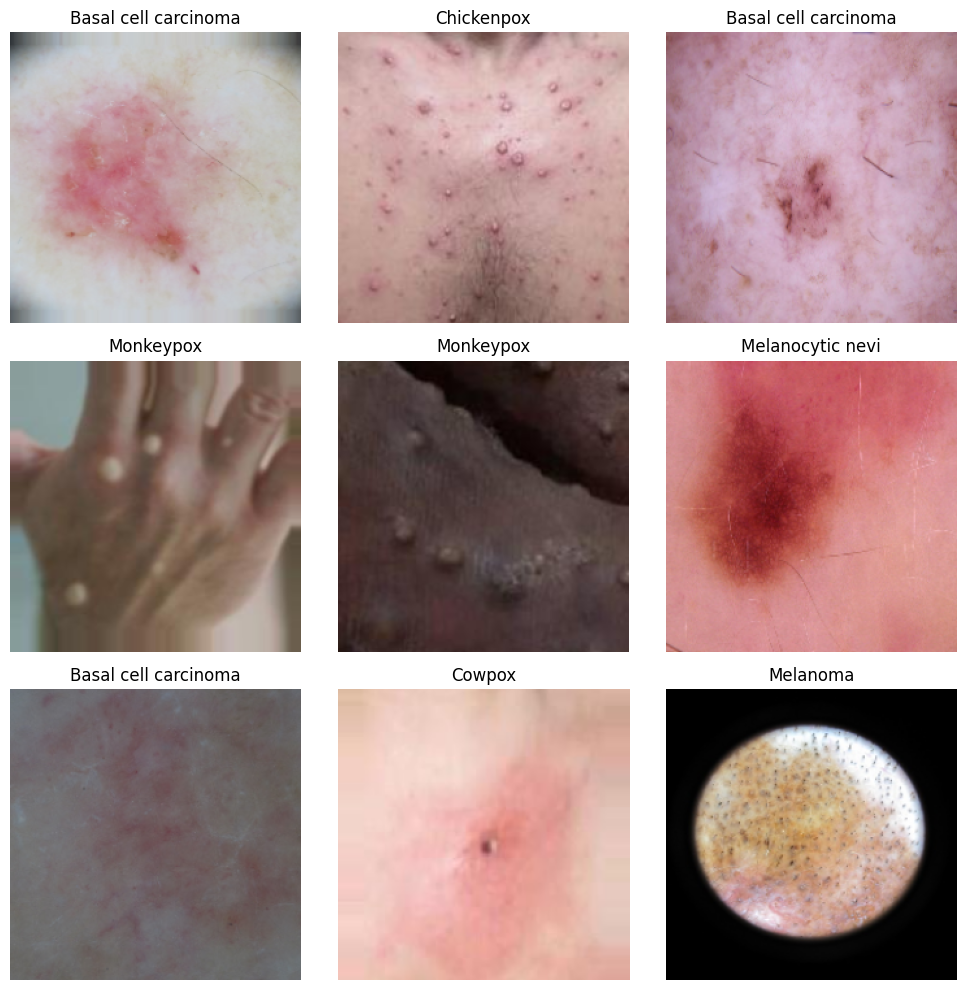

In [11]:
# Visualize some images from the dataset
plt.figure(figsize=(10, 10))
images, labels = next(dataset)  # Get one batch

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
def build_model():
    base_model = InceptionV3(include_top=False, weights='imagenet')
    # Freeze base model to not train it
    base_model.trainable = False

    model= models.Sequential()
    model.add(Input(shape=(224, 224, 3)))
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    # Fully Connected Layer
    model.add(Dense(256,activation="relu"))
    model.add(Dropout(0.5))
    #Out put layer
    model.add(Dense(num_classes, activation="softmax"))
     # Compile the model
    optimizer=Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    model.summary()
    return model,base_model

In [14]:
inception_model , base_model= build_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,330,926 (85.19 MB)

 Trainable params: 528,142 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [15]:

# Callbacks
checkpoint_callback = ModelCheckpoint(
    'best_Inception_model2.0.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1
)

# Combine all in a list
callbacks = [checkpoint_callback, early_stopping, reduce_lr]


In [16]:
# Train EfficientNetB0
# Initial Training
print("\n🔧 Training base model...")
history_inception = inception_model.fit(
    dataset,
    validation_data=val_set,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


🔧 Training base model...


c:\Users\ESHWAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.2351 - loss: 2.3865
Epoch 1: val_loss improved from inf to 1.48308, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 485s 886ms/step - accuracy: 0.2352 - loss: 2.3859 - val_accuracy: 0.4948 - val_loss: 1.4831 - learning_rate: 1.0000e-04
Epoch 2/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.4080 - loss: 1.6866
Epoch 2: val_loss improved from 1.48308 to 1.29365, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 475s 881ms/step - accuracy: 0.4080 - loss: 1.6865 - val_accuracy: 0.5858 - val_loss: 1.2936 - learning_rate: 1.0000e-04
Epoch 3/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.4605 - loss: 1.5299
Epoch 3: val_loss improved from 1.29365 to 1.18241, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 475s 882ms/step - accuracy: 0.4605 - loss: 1.5299 - val_accuracy: 0.6240 - val_loss: 1.1824 - learning_rate: 1.0000e-04
Epoch 4/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.5030 - loss: 1.4246
Epoch 4: val_loss improved from 1.18241 to 1.10691, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 473s 877ms/step - accuracy: 0.5031 - loss: 1.4246 - val_accuracy: 0.6262 - val_loss: 1.1069 - learning_rate: 1.0000e-04
Epoch 5/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.5152 - loss: 1.3739
Epoch 5: val_loss improved from 1.10691 to 1.08842, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 474s 880ms/step - accuracy: 0.5152 - loss: 1.3738 - val_accuracy: 0.6456 - val_loss: 1.0884 - learning_rate: 1.0000e-04
Epoch 6/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.5243 - loss: 1.3175
Epoch 6: val_loss improved from 1.08842 to 1.07828, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 474s 879ms/step - accuracy: 0.5243 - loss: 1.3175 - val_accuracy: 0.6432 - val_loss: 1.0783 - learning_rate: 1.0000e-04
Epoch 7/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.5434 - loss: 1.2788
Epoch 7: val_loss improved from 1.07828 to 1.06803, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 472s 876ms/step - accuracy: 0.5434 - loss: 1.2788 - val_accuracy: 0.6391 - val_loss: 1.0680 - learning_rate: 1.0000e-04
Epoch 8/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.5560 - loss: 1.2451
Epoch 8: val_loss improved from 1.06803 to 1.06475, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 475s 881ms/step - accuracy: 0.5559 - loss: 1.2451 - val_accuracy: 0.6489 - val_loss: 1.0647 - learning_rate: 1.0000e-04
Epoch 9/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.5546 - loss: 1.2315
Epoch 9: val_loss improved from 1.06475 to 1.04217, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 475s 881ms/step - accuracy: 0.5546 - loss: 1.2315 - val_accuracy: 0.6423 - val_loss: 1.0422 - learning_rate: 1.0000e-04
Epoch 10/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.5622 - loss: 1.1992
Epoch 10: val_loss improved from 1.04217 to 1.02849, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 473s 878ms/step - accuracy: 0.5622 - loss: 1.1992 - val_accuracy: 0.6560 - val_loss: 1.0285 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


In [17]:
history_inception= inception_model.fit(
    dataset,
    validation_data=val_set,
    initial_epoch=10,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 11/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.5678 - loss: 1.1769
Epoch 11: val_loss improved from 1.02849 to 1.00872, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 473s 877ms/step - accuracy: 0.5678 - loss: 1.1769 - val_accuracy: 0.6601 - val_loss: 1.0087 - learning_rate: 1.0000e-04
Epoch 12/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.5867 - loss: 1.1464
Epoch 12: val_loss did not improve from 1.00872
539/539 ━━━━━━━━━━━━━━━━━━━━ 473s 877ms/step - accuracy: 0.5867 - loss: 1.1464 - val_accuracy: 0.6473 - val_loss: 1.0140 - learning_rate: 1.0000e-04
Epoch 13/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.5785 - loss: 1.1471
Epoch 13: val_loss improved from 1.00872 to 0.98848, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 472s 875ms/step - accuracy: 0.5785 - loss: 1.1471 - val_accuracy: 0.6508 - val_loss: 0.9885 - learning_rate: 1.0000e-04
Epoch 14/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.5831 - loss: 1.1373
Epoch 14: val_loss did not improve from 0.98848
539/539 ━━━━━━━━━━━━━━━━━━━━ 474s 880ms/step - accuracy: 0.5831 - loss: 1.1373 - val_accuracy: 0.6579 - val_loss: 0.9887 - learning_rate: 1.0000e-04
Epoch 15/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.5835 - loss: 1.1308
Epoch 15: val_loss improved from 0.98848 to 0.98779, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 475s 881ms/step - accuracy: 0.5835 - loss: 1.1308 - val_accuracy: 0.6587 - val_loss: 0.9878 - learning_rate: 1.0000e-04
Epoch 16/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.5991 - loss: 1.0899
Epoch 16: val_loss improved from 0.98779 to 0.98565, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 470s 872ms/step - accuracy: 0.5991 - loss: 1.0899 - val_accuracy: 0.6598 - val_loss: 0.9856 - learning_rate: 1.0000e-04
Epoch 17/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.6067 - loss: 1.0839
Epoch 17: val_loss improved from 0.98565 to 0.95987, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 474s 879ms/step - accuracy: 0.6067 - loss: 1.0839 - val_accuracy: 0.6615 - val_loss: 0.9599 - learning_rate: 1.0000e-04
Epoch 18/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.6039 - loss: 1.0796
Epoch 18: val_loss did not improve from 0.95987
539/539 ━━━━━━━━━━━━━━━━━━━━ 472s 876ms/step - accuracy: 0.6039 - loss: 1.0796 - val_accuracy: 0.6598 - val_loss: 0.9609 - learning_rate: 1.0000e-04
Epoch 19/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.6002 - loss: 1.0821
Epoch 19: val_loss did not improve from 0.95987
539/539 ━━━━━━━━━━━━━━━━━━━━ 472s 875ms/step - accuracy: 0.6002 - loss: 1.0821 - val_accuracy: 0.6492 - val_loss: 0.9741 - learning_rate: 1.0000e-04
Epoch 20/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.6068 - loss: 1.0701
Epoch 20: val_loss improved from 0.95987 to 0.93623, saving model to best_Inception_model2.0.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 472s 875ms/step - accuracy: 0.6068 - loss: 1.0701 - val_accuracy: 0.6735 - val_loss: 0.9362 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 20.


In [18]:
# Fine-Tuning: Unfreeze last 60 layers
print("\n🔧 Fine-tuning last 60 layers...")

base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False



🔧 Fine-tuning last 60 layers...


In [19]:
# Re-compile with lower learning rate
inception_model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [20]:

# Callbacks
checkpoint_callback = ModelCheckpoint(
    'best_Inception_mode_fine tunedl.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1
)

# Combine all in a list
callbacks = [checkpoint_callback, early_stopping, reduce_lr]


In [21]:
print("\n🚀 Starting Fine-tuning...")
history_efficientnet_finetune = inception_model.fit(
    dataset,
    validation_data=val_set,
    epochs=30,
    initial_epoch=20,
    callbacks=callbacks,
    verbose=1
)


🚀 Starting Fine-tuning...
Epoch 21/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.5003 - loss: 1.3974
Epoch 21: val_loss improved from inf to 0.96786, saving model to best_Inception_mode_fine tunedl.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 501s 907ms/step - accuracy: 0.5004 - loss: 1.3971 - val_accuracy: 0.6593 - val_loss: 0.9679 - learning_rate: 1.0000e-05
Epoch 22/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.6047 - loss: 1.0865
Epoch 22: val_loss improved from 0.96786 to 0.90184, saving model to best_Inception_mode_fine tunedl.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 492s 912ms/step - accuracy: 0.6048 - loss: 1.0864 - val_accuracy: 0.6765 - val_loss: 0.9018 - learning_rate: 1.0000e-05
Epoch 23/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.6395 - loss: 0.9895
Epoch 23: val_loss improved from 0.90184 to 0.84389, saving model to best_Inception_mode_fine tunedl.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 492s 913ms/step - accuracy: 0.6395 - loss: 0.9895 - val_accuracy: 0.6984 - val_loss: 0.8439 - learning_rate: 1.0000e-05
Epoch 24/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.6651 - loss: 0.9238
Epoch 24: val_loss improved from 0.84389 to 0.81414, saving model to best_Inception_mode_fine tunedl.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 492s 913ms/step - accuracy: 0.6651 - loss: 0.9238 - val_accuracy: 0.7052 - val_loss: 0.8141 - learning_rate: 1.0000e-05
Epoch 25/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.6835 - loss: 0.8786
Epoch 25: val_loss improved from 0.81414 to 0.80474, saving model to best_Inception_mode_fine tunedl.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 487s 902ms/step - accuracy: 0.6835 - loss: 0.8786 - val_accuracy: 0.7101 - val_loss: 0.8047 - learning_rate: 1.0000e-05
Epoch 26/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.6973 - loss: 0.8364
Epoch 26: val_loss improved from 0.80474 to 0.76825, saving model to best_Inception_mode_fine tunedl.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 491s 910ms/step - accuracy: 0.6973 - loss: 0.8364 - val_accuracy: 0.7249 - val_loss: 0.7683 - learning_rate: 1.0000e-05
Epoch 27/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.7053 - loss: 0.8068
Epoch 27: val_loss did not improve from 0.76825
539/539 ━━━━━━━━━━━━━━━━━━━━ 502s 931ms/step - accuracy: 0.7053 - loss: 0.8068 - val_accuracy: 0.7219 - val_loss: 0.7690 - learning_rate: 1.0000e-05
Epoch 28/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.7253 - loss: 0.7596
Epoch 28: val_loss improved from 0.76825 to 0.74258, saving model to best_Inception_mode_fine tunedl.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 517s 959ms/step - accuracy: 0.7253 - loss: 0.7596 - val_accuracy: 0.7281 - val_loss: 0.7426 - learning_rate: 1.0000e-05
Epoch 29/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.7308 - loss: 0.7347
Epoch 29: val_loss improved from 0.74258 to 0.73292, saving model to best_Inception_mode_fine tunedl.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 521s 966ms/step - accuracy: 0.7309 - loss: 0.7347 - val_accuracy: 0.7347 - val_loss: 0.7329 - learning_rate: 1.0000e-05
Epoch 30/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.7378 - loss: 0.7146
Epoch 30: val_loss improved from 0.73292 to 0.71431, saving model to best_Inception_mode_fine tunedl.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 527s 978ms/step - accuracy: 0.7378 - loss: 0.7146 - val_accuracy: 0.7399 - val_loss: 0.7143 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 30.


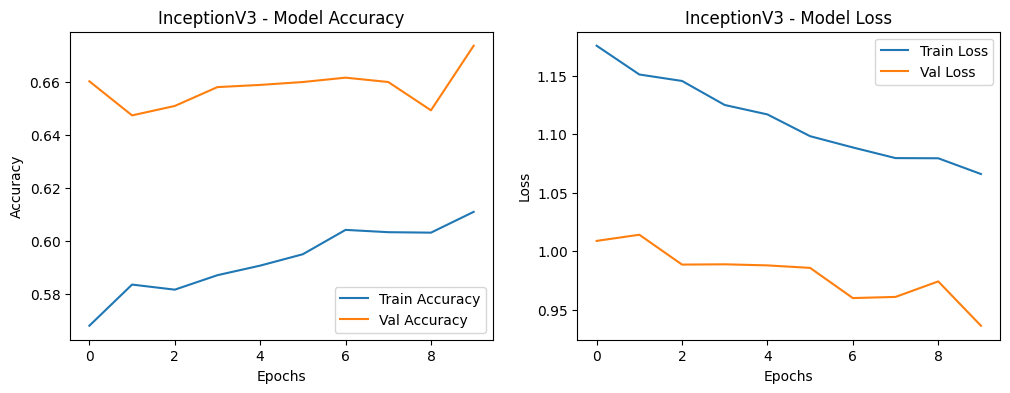

In [22]:
# Plot Training History
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{title} - Model Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{title} - Model Loss')

    plt.show()

# Plot Training Results for EfficientNetB0
plot_history(history_inception, "InceptionV3")

In [24]:
# Combine histories
def combine_histories(h1, h2):
    for key in h1.history:
        h1.history[key].extend(h2.history[key])
    return h1

In [25]:
history = combine_histories(history_inception, history_efficientnet_finetune)

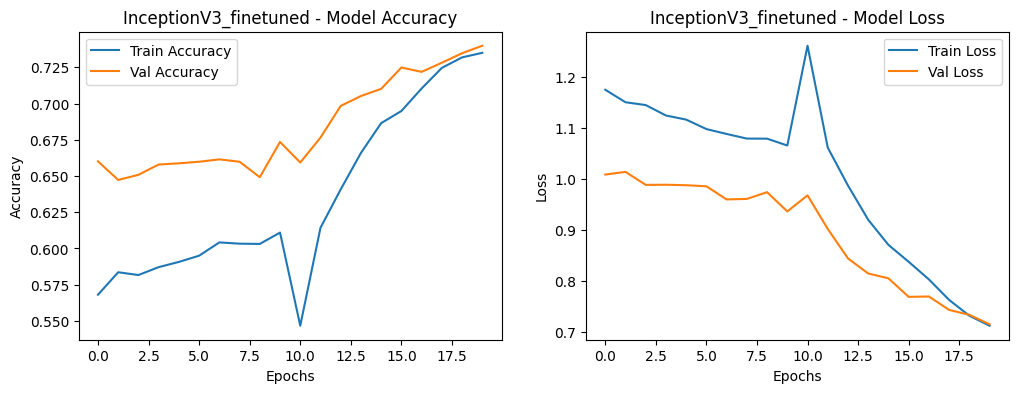

In [26]:
plot_history(history, "InceptionV3_finetuned")

In [27]:
# Evaluate on test dataset
print("\n📊 Evaluating on test set...")
loss, accuracy = inception_model.evaluate(test_set)
print(f"Test Accuracy: {accuracy:.4f} | Test Loss: {loss:.4f}")


📊 Evaluating on test set...


c:\Users\ESHWAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 95s 822ms/step - accuracy: 0.7424 - loss: 0.7209
Test Accuracy: 0.7374 | Test Loss: 0.7266


In [30]:
class_names_test = list(test_set.class_indices.keys())

In [31]:
class_names_test

['Actinic keratoses',
 'Basal cell carcinoma',
 'Benign keratosis-like lesions',
 'Chickenpox',
 'Cowpox',
 'Dermatofibroma',
 'HFMD',
 'Healthy',
 'Measles',
 'Melanocytic nevi',
 'Melanoma',
 'Monkeypox',
 'Squamous cell carcinoma',
 'Vascular lesions']

In [32]:
from tensorflow.keras.models import load_model

# Load model
model = load_model("best_Inception_mode_fine tunedl.h5")


In [33]:
from tensorflow.keras.preprocessing import image

In [34]:
def predict_image(image_path):
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0  # Rescale

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    print(f"📸 Predicted: {predicted_class} ({confidence:.2f}%)")

In [36]:
def preprocess_image(image_path, img_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # img_array = img_array / 255.0  # Normalize between 0 and 1
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [37]:
# Path to a new image
image_path = "test/Squamous cell carcinoma/ISIC_0026981.jpg"
processed_image = preprocess_image(image_path)

# Predict
prediction = model.predict(processed_image)

# Get class
predicted_class = np.argmax(prediction, axis=1)

print("Predicted Class Index:", predicted_class[0])
print("Probabilities:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class Index: 7
Probabilities: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 4.4491603e-35 0.0000000e+00 0.0000000e+00]]


In [38]:
class_names = ['Actinic keratoses',
 'Basal cell carcinoma',
 'Benign keratosis-like lesions',
 'Chickenpox',
 'Cowpox',
 'Dermatofibroma',
 'HFMD',
 'Healthy',
 'Measles',
 'Melanocytic nevi',
 'Melanoma',
 'Monkeypox',
 'Squamous cell carcinoma',
 'Vascular lesions']
print("Predicted Class Label:", class_names[predicted_class[0]])


Predicted Class Label: Healthy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


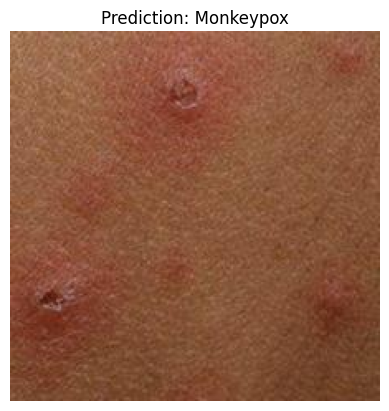

In [41]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_skin_cancer(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand for batch dimension

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_label = class_names_test[class_index]

    plt.imshow(img)
    plt.title(f"Prediction: {class_label}")
    plt.axis("off")
    plt.show()

# Test the model with an image
predict_skin_cancer("test/Chickenpox/CHP_02_01_8.jpg", model)


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='test',
    target_size=(224, 224),    
    batch_size=32,
    class_mode='categorical', 
    shuffle=False
)


Found 3674 images belonging to 14 classes.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, roc_curve,auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from tensorflow.keras import backend as K

In [3]:
model = load_model('best_Inception_mode_fine tunedl.h5')

c:\Users\ESHWAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 60s 499ms/step


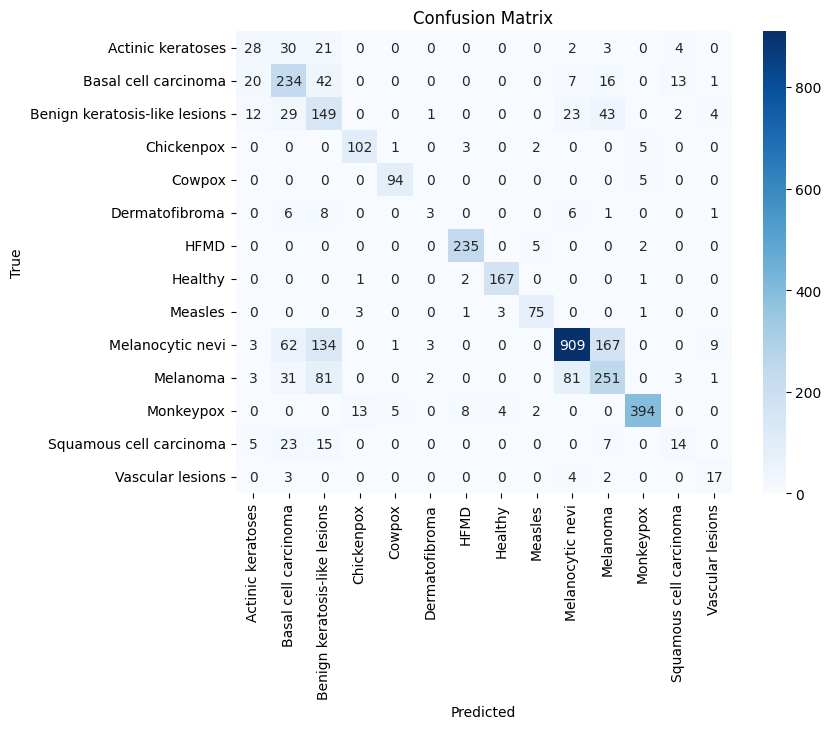

In [4]:
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [5]:
class_names = list(test_generator.class_indices.keys())
print("Class names:", class_names)
print("Class indices:", test_generator.class_indices)

Class names: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Class indices: {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 'Benign keratosis-like lesions': 2, 'Chickenpox': 3, 'Cowpox': 4, 'Dermatofibroma': 5, 'HFMD': 6, 'Healthy': 7, 'Measles': 8, 'Melanocytic nevi': 9, 'Melanoma': 10, 'Monkeypox': 11, 'Squamous cell carcinoma': 12, 'Vascular lesions': 13}


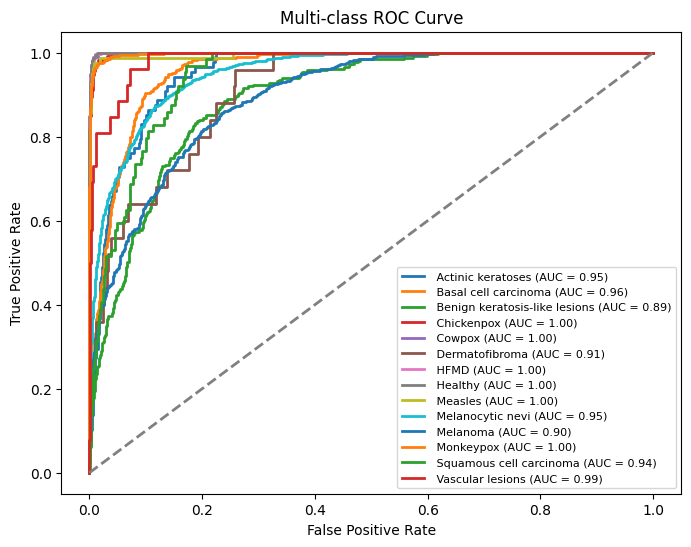

In [6]:
true_classes = test_generator.classes
n_classes = len(test_generator.class_indices)
true_classes_bin = label_binarize(true_classes, classes=range(n_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right', fontsize=8)
plt.show()

In [7]:
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)

report_df = pd.DataFrame(report).transpose()

print("\nClassification Report:")
print(report_df)


Classification Report:
                               precision    recall  f1-score      support
Actinic keratoses               0.394366  0.318182  0.352201    88.000000
Basal cell carcinoma            0.559809  0.702703  0.623169   333.000000
Benign keratosis-like lesions   0.331111  0.566540  0.417952   263.000000
Chickenpox                      0.857143  0.902655  0.879310   113.000000
Cowpox                          0.930693  0.949495  0.940000    99.000000
Dermatofibroma                  0.333333  0.120000  0.176471    25.000000
HFMD                            0.943775  0.971074  0.957230   242.000000
Healthy                         0.959770  0.976608  0.968116   171.000000
Measles                         0.892857  0.903614  0.898204    83.000000
Melanocytic nevi                0.880814  0.705745  0.783621  1288.000000
Melanoma                        0.512245  0.554084  0.532344   453.000000
Monkeypox                       0.965686  0.924883  0.944844   426.000000
Squamous cell 

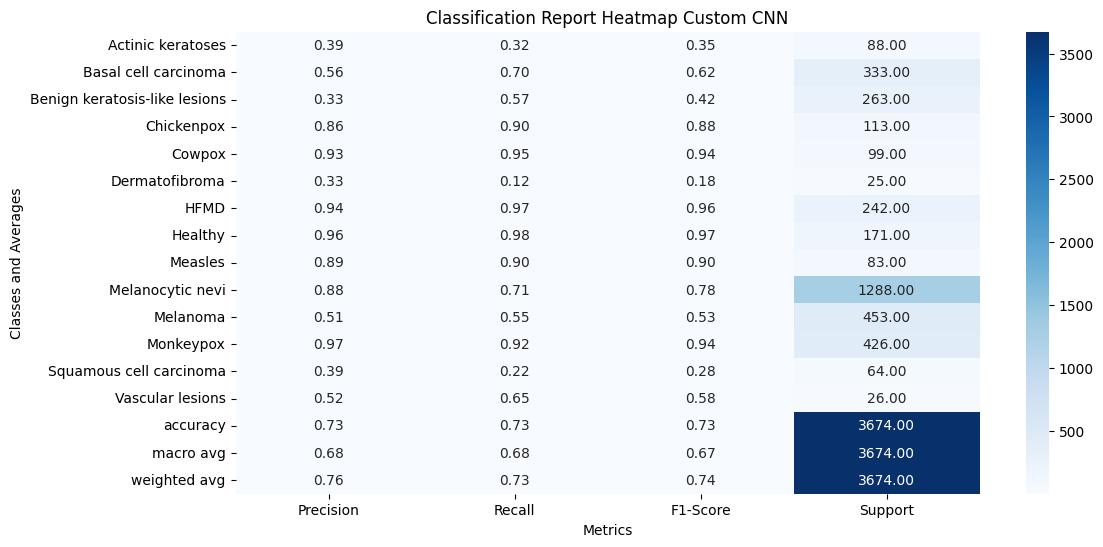

In [8]:
metrics_df = report_df[['precision', 'recall', 'f1-score', 'support']].iloc[:-3] 

accuracy = report_df.loc['accuracy', 'precision']
macro_avg = report_df.loc['macro avg', ['precision', 'recall', 'f1-score', 'support']]
weighted_avg = report_df.loc['weighted avg', ['precision', 'recall', 'f1-score', 'support']]


metrics_df.loc['accuracy'] = [accuracy, accuracy, accuracy, 3674]  
metrics_df.loc['macro avg'] = macro_avg  
metrics_df.loc['weighted avg'] = weighted_avg  

plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", cbar=True, fmt=".2f", 
            xticklabels=['Precision', 'Recall', 'F1-Score', 'Support'], 
            yticklabels=metrics_df.index)
plt.title("Classification Report Heatmap Custom CNN")
plt.xlabel("Metrics")
plt.ylabel("Classes and Averages")
plt.show()

In [4]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from collections import defaultdict

def evaluate_model_on_test_folder(model_path, test_folder, img_height=224, img_width=224):
    model = load_model(model_path)
    class_names = sorted(os.listdir(test_folder))
    correct_counts = defaultdict(int)
    total_counts = defaultdict(int)

    # Supported image extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

    for class_name in class_names:
        class_path = os.path.join(test_folder, class_name)
        if not os.path.isdir(class_path):
            continue  # Skip non-folder files

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)

            # Skip non-image files
            if not any(img_file.lower().endswith(ext) for ext in valid_extensions):
                continue

            try:
                # Load and preprocess the image
                img = image.load_img(img_path, target_size=(img_height, img_width))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = img_array / 255.0

                # Predict
                predictions = model.predict(img_array, verbose=0)
                predicted_index = np.argmax(predictions[0])
                predicted_label = class_names[predicted_index]

                total_counts[class_name] += 1
                if predicted_label == class_name:
                    correct_counts[class_name] += 1

                # Print the actual and predicted label
                print(f"Actual: {class_name} - Predicted: {predicted_label}")

            except Exception as e:
                print(f"Skipping file {img_path}: {e}")

    print("\nPrediction Summary:")
    for class_name in class_names:
        print(f"Class: {class_name} - Correct Predictions: {correct_counts[class_name]} / {total_counts[class_name]}")

    total_correct = sum(correct_counts.values())
    total_samples = sum(total_counts.values())
    overall_accuracy = total_correct / total_samples * 100 if total_samples > 0 else 0
    print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")


In [5]:
evaluate_model_on_test_folder(
    model_path='best_Inception_mode_fine tunedl.h5',
    test_folder='test',
    img_height=224,
    img_width=224
)


Actual: Actinic keratoses - Predicted: Actinic keratoses
Actual: Actinic keratoses - Predicted: Actinic keratoses
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Actinic keratoses
Actual: Actinic keratoses - Predicted: Basal cell carcinoma
Actual: Actinic keratoses - Predicted: Squamous cell carcinoma
Actual: Actinic keratoses - Predicted: Basal cell carcinoma
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Actinic keratoses
Actual: Actinic keratoses - Predicted: Basal cell carcinoma
Actual: Actinic keratoses - Predicted: Actinic keratoses
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Squamous cell carcinoma
Actual: Actinic keratoses - Predicted: Actinic keratoses
Actual: